# Flight Passenger Predictions

This is a simple example of using an LSTM for predicting the number of monthly flight passengers. The (real) data spans the years 1949-1960, and thus it contains 12x12=144 entries with the number of passengers (in thousands). Your job is to predict the next point(s) in the sequence.

There are several ML packages, which have an LSTM implementation, and probably most widely used are:
* Keras Tensorflow (see e.g. https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
* PyTorch (see e.g. https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)

***

Author: Troels Petersen<br>
Date: 15th of May 2022

In [1]:
# LSTM for international airline passengers problem with regression framing
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
from torch import nn
from tqdm import tqdm

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
plt.rc('legend', fontsize=12)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.constrained_layout.use'] = True
fs = (10, 6)

/opt/anaconda3/envs/aml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Convert an array of values into a dataset matrix:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

## Load and prepare dataset:

In [3]:
# Fix random seed for reproducibility:
np.random.seed(42)

# Load the dataset:
# dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataframe = read_csv('./Data/station_6190.csv', usecols=[12], engine='python')  # 10 pressure , 12 temp
# dataframe = dataframe[:50]
dataset = dataframe.values
dataset = dataset.astype('float32')


# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape into X = t and Y = t + 1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

### Have a look at the data

In [4]:
trainX.shape, trainY.shape

((66686, 10, 1), (66686,))

Given an `x` such as

In [5]:
trainX[15, 0, :]

array([0.33100232], dtype=float32)

The goal is to predict the next value of the sequence, we we have stored as

In [6]:
trainY[15]

0.2937063

In [7]:
# Move to PyTorch tensors:
trainX = torch.tensor(trainX, dtype=torch.float)
trainY = torch.tensor(trainY, dtype=torch.float)
testX  = torch.tensor(testX, dtype=torch.float)
testY  = torch.tensor(testY, dtype=torch.float)

## Make an LSTM model:

In [8]:
class Net(nn.Module):
    def __init__(self, hidden_size=8):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x, _ = self.lstm(x)  # Run LSTM and store the hidden layer outputs
        x = x[:, -1, :]  # take the last hidden layer
        x = self.linear(x) # a normal dense layer
        return x


net = Net()

## Train the model model:

In [9]:
opt = torch.optim.Adam(net.parameters(), lr=5e-3)
progress_bar = tqdm(range(1000))
for epoch in progress_bar:
    prediction = net(trainX)
    loss = torch.sum((prediction.flatten() - trainY.flatten())**2)
    progress_bar.set_description(f'Loss = {float(loss)}')
    loss.backward()
    opt.step()
    opt.zero_grad()

Loss = 26.39319610595703: 100%|██████████| 1000/1000 [06:32<00:00,  2.55it/s]


In [10]:
print(loss)

tensor(26.3932, grad_fn=<SumBackward0>)


## Inspect the result/performance:

Train Score: 0.85 RMSE
Test Score: 0.84 RMSE


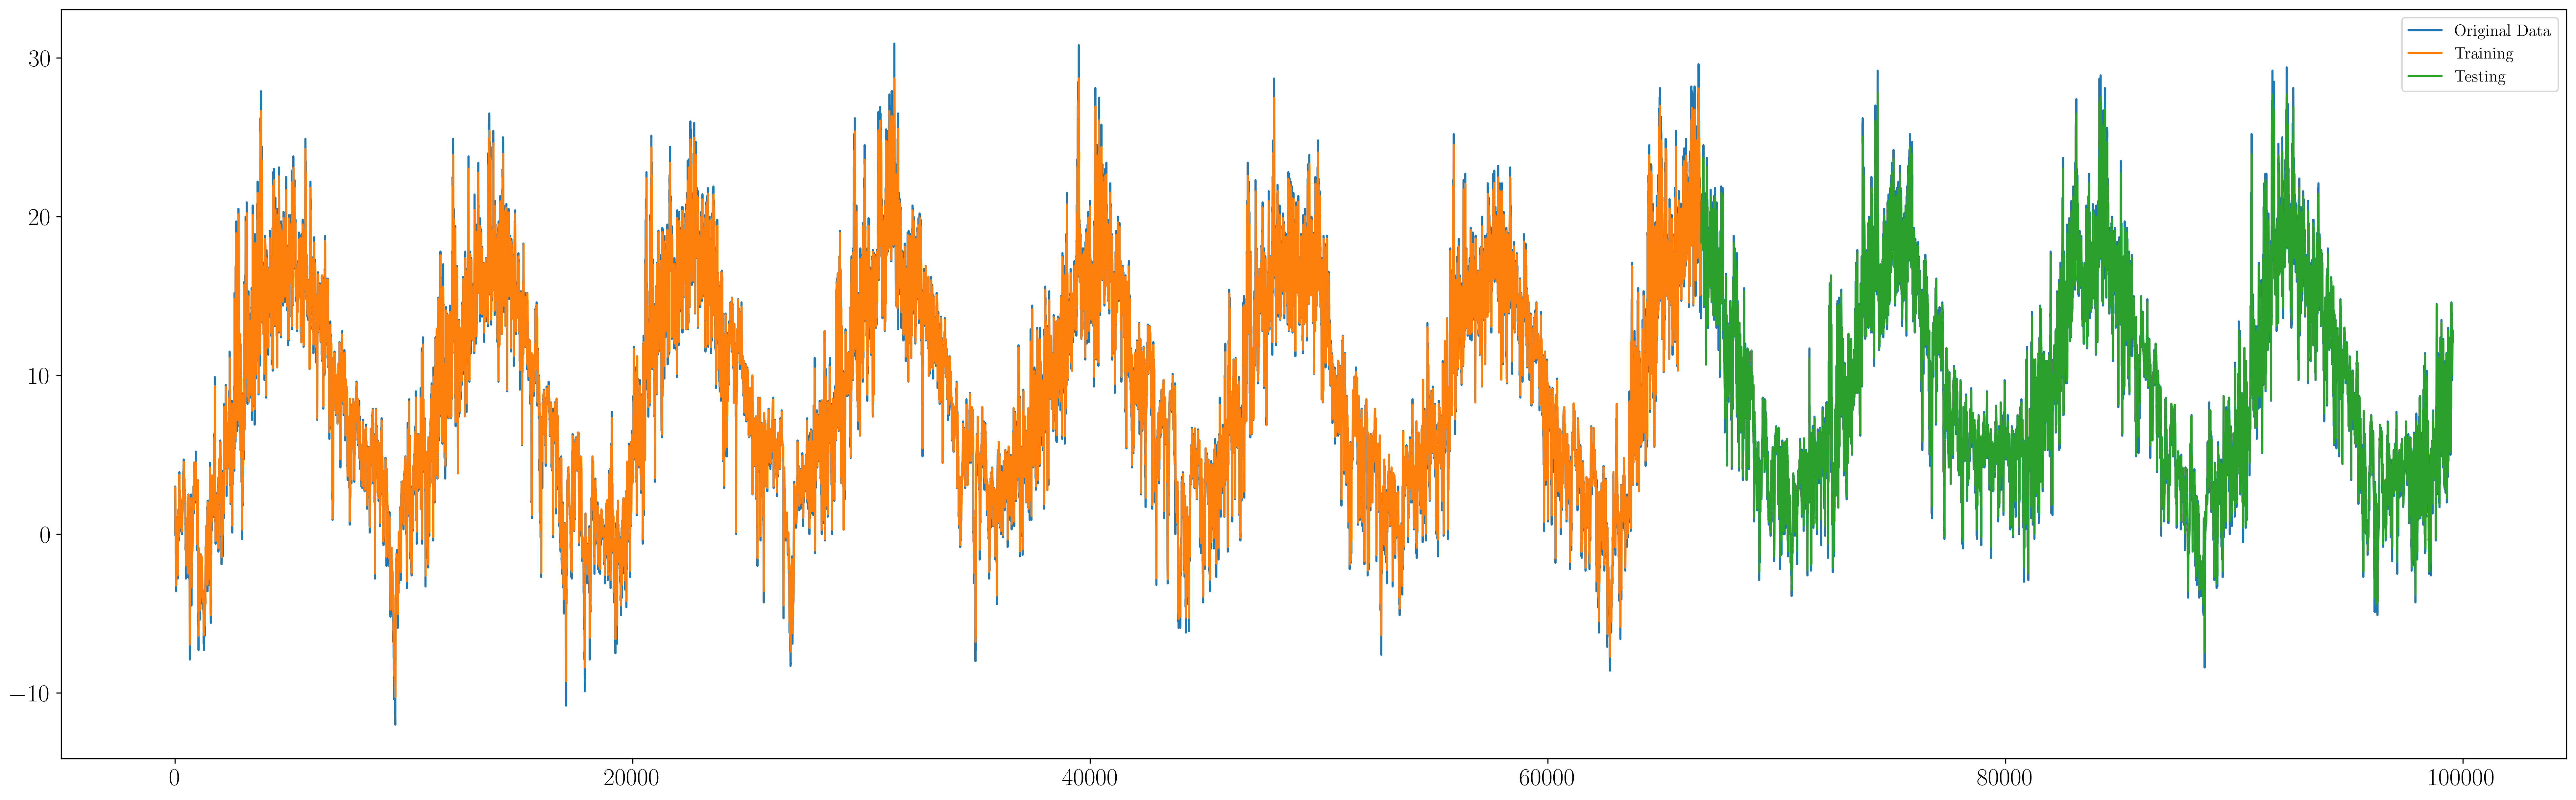

In [11]:
# make predictions
with torch.no_grad():
    trainPredict = net(trainX).numpy()
    testPredict = net(testX).numpy()


# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY_inv = scaler.inverse_transform([trainY.numpy()])
testPredict = scaler.inverse_transform(testPredict)
testY_inv = scaler.inverse_transform([testY.numpy()])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inv[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_inv[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions

plt.figure(figsize=(26,8))
plt.plot(scaler.inverse_transform(dataset), label=r'Original Data')
plt.plot(trainPredictPlot, label=r'Training')
plt.plot(testPredictPlot, label=r'Testing')
# plt.xlim([60000, 100000])
plt.legend()
plt.show()

In [12]:
plot = np.array([12.7, 12.4, 12.0, 11.8, 12.2, 12.5, 12.9, 13.3, 14.1, 15.1])
v = np.array([12.7, 12.4, 12.0, 11.8, 12.2, 12.5, 12.9, 13.3, 14.1, 15.1])
v = v.reshape(-1, 1)
v = scaler.transform(v)
v = np.reshape(v, (1, len(v), 1))

print(v.shape)
vtorch = torch.tensor(v, dtype=torch.float)

with torch.no_grad():
    pred = net(vtorch).numpy()

pred = scaler.inverse_transform(pred)
print(pred)

(1, 10, 1)
[[14.503556]]


In [13]:
plot = plot.reshape((len(plot), 1))
print(plot.shape, pred.shape)

(10, 1) (1, 1)


In [14]:
print(plot.shape, pred.shape)

(10, 1) (1, 1)


Percent Error	5.82 %
(10, 1) (10,)


/opt/anaconda3/envs/aml/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


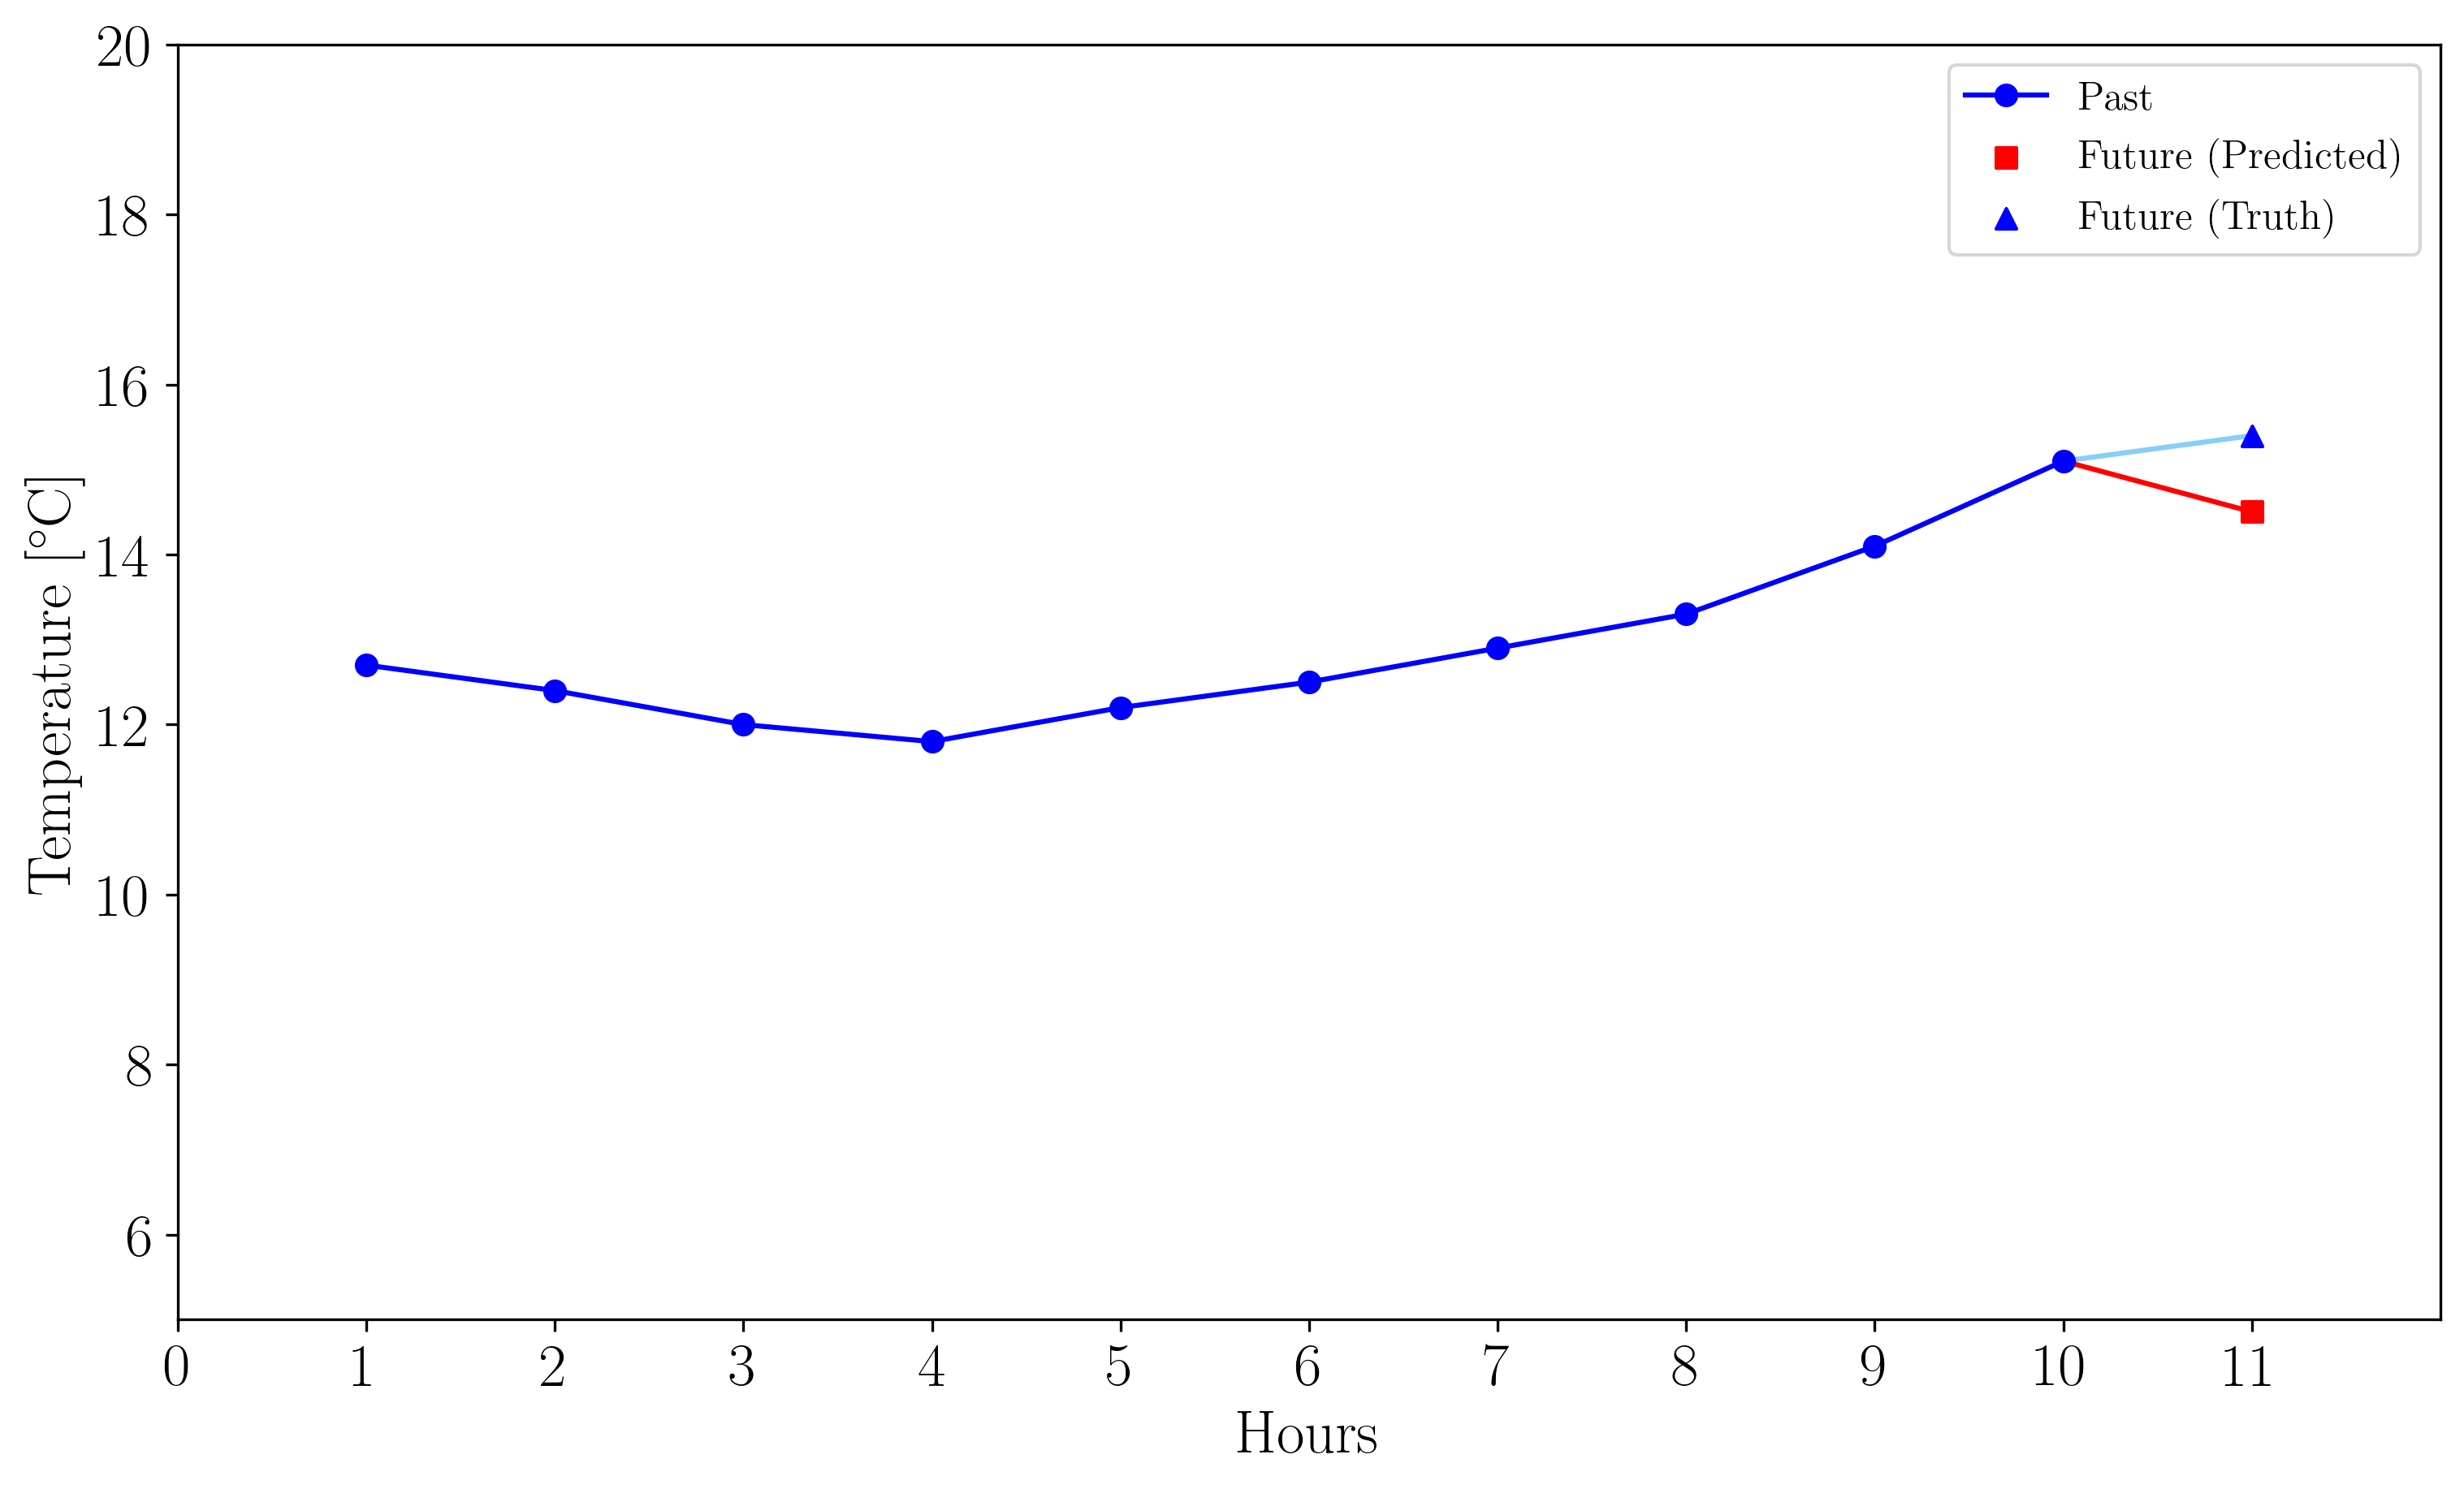

In [15]:
# plot = np.concatenate((plot, pred))
truth = 15.4
pred = float(pred)

time = np.arange(1, len(plot)+1)
print('Percent Error\t{:.2f} %'.format(np.abs(pred - truth)/truth * 100))

print(plot.shape, time.shape)

# plot city
plt.figure(figsize=fs)
plt.plot(time, plot, label=r'Past', marker='o', c='b', zorder=2)
plt.scatter(11, pred, label=r'Future (Predicted)', marker='s', c='r', zorder=1)
plt.scatter(11, truth, label=r'Future (Truth)', c='b', marker='^', zorder=2)
plt.plot([time[-1], time[-1] + 1], [plot[-1], truth], c='lightskyblue', zorder=1)
plt.plot([time[-1], time[-1] + 1], [plot[-1], pred], c='r', zorder=1)
plt.xlim([0, 12])
plt.ylim([5, 20])
plt.xlabel(r'Hours')
plt.ylabel(r'Temperature [$^{\circ}$C]')
plt.xticks(np.arange(0, 12))
plt.legend()
plt.savefig('./Figures/june8onehour1.png')
plt.show()

In [16]:
0.84**2

0.7055999999999999